In [1]:
%matplotlib inline

In [44]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import numpy as np
import pandas as pd
import tensorflow as tf
sess = tf.Session()

from keras import backend as K
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense
from keras.regularizers import l2
from keras.optimizers import SGD

import matplotlib.pyplot as plt

In [45]:
import dicom

In [46]:
K.set_session(sess)

In [47]:
PathDicom = "../data/challenge_training/"
lstFilesDCM = []  # create an empty list
stFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

In [48]:
# Get ref file
RefDs = dicom.read_file(lstFilesDCM[1])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))


In [49]:
print(ConstPixelDims)

(256, 256, 16863)


In [50]:
print(ConstPixelSpacing)

(1.5625, 1.5625, 8.0)


In [51]:
x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

TypeError: Dimensions of C (64, 64) are incompatible with X (257) and/or Y (257); see help(pcolormesh)

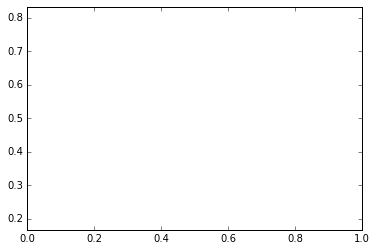

In [53]:
plt.figure(dpi=300)
plt.axes().set_aspect('equal', 'datalim')
plt.set_cmap(plt.gray())
plt.pcolormesh(x, y, np.flipud(ArrayDicom[:, :, 1]))

In [54]:
from scipy.misc import imresize

In [55]:
# The array is sized based on 'ConstPixelDims'
ArrayDicom = np.zeros((64, 64, 16863), dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # read the file
    ds = dicom.read_file(filenameDCM)
    # store the raw image data
    if len(ds.pixel_array.shape) == 2:
        ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = imresize(ds.pixel_array,size=(64,64))

ValueError: total size of new array must be unchanged

In [41]:
model = Sequential()
model.add(Convolution2D(100, 11, 11, border_mode='same', input_shape=(1, 64, 64),init='glorot_normal'))
model.add(MaxPooling2D(pool_size=(6, 6)))
model.add(Flatten())
model.add(Dense(1024))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_6 (Convolution2D)  (None, 100, 64, 64)   12200       convolution2d_input_6[0][0]      
____________________________________________________________________________________________________
maxpooling2d_3 (MaxPooling2D)    (None, 100, 10, 10)   0           convolution2d_6[0][0]            
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 10000)         0           maxpooling2d_3[0][0]             
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1024)          10241024    flatten_2[0][0]                  
Total params: 10253224
____________________________________________________________________

In [ ]:


def train(data_path,fraction = 0.7,nb_epoch=100):

    n_train = int(np.floor(fraction*n_samples))
    print("Size of training set: "+str(n_train))

    print('Building Model')
    
    model = Sequential()
    model.add(Convolution2D(8, 115, 5, border_mode='same', input_shape=(115, 553,1),init='glorot_normal'))
    model.add(UpSampling2D(size=(1,2)))
    model.add(Convolution2D(8, 1, 3, border_mode='same',init='glorot_normal'))
    model.add(Convolution2D(1, 115, 1, border_mode='valid',init='glorot_normal'))

    
    sgd = SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer='sgd')
    model.summary()
    
    history = model.fit_generator(generate_data_from_h5(data_path,training_fraction= fraction),samples_per_epoch=n_train, nb_epoch=nb_epoch,nb_worker=4)
    
    
    # Saving weights, evolution of loss
    #model.save("/awsspace/thomas/weights/simple_cnn_zeropad.h5")
    model.save("/awsspace/thomas/weights/simple_cnn_prototype.h5")
   
    loss_history = history.history["loss"]
    numpy_loss_history = np.array(loss_history)
    numpy_loss_history.tofile("/awsspace/thomas/weights/simple_cnn_prototype.txt", sep = ",")
    
    print("Training finished, weights saved.")

train(PATH_H5,fraction = 0.7,nb_epoch=200)
